## Time Series Momentum on Nifty Next 50 Stocks

### Author: Jay Parmar

#### Date: 4th Aug 2021

In this notebook, I backtest time series momentum strategy on nifty next 50 stocks from 2011 to 2020. I use Zipline to perform event-driven backtesting. The steps for the same are as follows:

1. Import required libraries
2. Define initial parameters in the `initialize` function
3. Define `rebalance` function that implements the strategy. I define three versions of it:
    - Creates the portfolio using the equal allocation method
    - creates the portfolio by closing existing positions and opening them again
    - Creates the portfolio using the mean-variance allocation method
4. Define method to analyze the portfolio
5. Run the backtesting
6. Analyze the portfolio using `pyfolio` library.

I use the historical nifty next 50 constituents collated from the NSE website. This is to ensure that backtesting does not have any survivorship bias.

In [1]:
# Import necessary libraries
import pandas as pd
import talib as ta
import pyfolio as pf
import matplotlib.pyplot as plt
import warnings

from zipline import run_algorithm
from zipline.api import (symbol, set_benchmark, order_target_percent, schedule_function, get_datetime, 
                         date_rules, time_rules)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')

In [2]:
# Import libraries for performing portfolio weights optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import CLA

In [3]:
# Define initial parameters
initial_capital = 150000

def initialize(context):
    c = context
    
    set_benchmark(symbol('nifty_next_50'))
    
    c.cons_file = pd.read_csv('Nifty_next_50_Constituents.csv')
    
    c.lookback = 150
    c.max_positions = 10
    
    # For quarterly rebalancing
    context.counter = 0
    
    # Used only for progress output
    context.last_month = initial_capital
    
    schedule_function(rebalance,
                     date_rule=date_rules.week_start() ,
                     time_rule=time_rules.market_open(hours=0, minutes=15))

The following code implements the helper methods for rebalancing portfolio and displaying the progress.

In [4]:
def handle_data(context, data):
    pass

def rebalance_freq(context, data):  
    freq_month = 3  
    context.counter += 1  
    if context.counter == freq_month:  
        rebalance_mvo(context, data)  
        context.counter = 0

# output performance
def output_progress(context):
    # Output performance numbers during backtest run on monthly basis
    # Get today's date
    today = get_datetime().date()
    
    # Calculate percent difference since last month
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    
    # Print performance, format as percent with two decimals.
    print("{} - Last Month Result: {:.2%}".format(today, perf_pct))
    
    # Remember today's portfolio value for next month's calculation
    context.last_month = context.portfolio.portfolio_value

The following function creates the portfolio using the mean-variance framework.

In [ ]:
def rebalance_mvo(context, data):
    c = context
    
    # Close existing positions - Iterate through all existing positions
    for stock in context.portfolio.positions:
        order_target_percent(stock, 0.0)
    
    
    cleaned_weights = []
    
    # Write progress output during the backtest
    # output_progress(context)
    
    # Get current month - Format: Jan-2017
    # This is used to get constituents for every month
    current_month = get_datetime().strftime('%b-%y')
    
    # Get the current month stocks to trade
    stocks = c.cons_file[current_month].dropna().tolist()
    
    # Remove duplicates from the list
    stocks = list(set(stocks))
    
    # Create universe using all stock for the particular month
    c.universe = [symbol(stock) for stock in stocks]
    
    # Fetch historical data
    c.hist = data.history(c.universe, 'close', c.lookback, '1d')
    c.hist.dropna(inplace=True)
    
    # TODO: Drop past 30 days data
    # c.hist = c.hist.iloc[:-22]
    
    # Calculate daily returns for each stock
    c.daily_returns = c.hist.pct_change()
    
    # print('Current Month:', current_month)
    # print(c.hist.info())
    # print(c.daily_returns.info())
    
    # Calculate cumulative returns for each stock and fetch the last value
    c.cum_net_returns = ((1 + c.daily_returns).cumprod() - 1).iloc[-1]
       
    # Rank the stocks according to the cumulative returns
    c.cum_net_returns_sorted = c.cum_net_returns.sort_values(ascending=False)
    
    c.updated_universe = list(c.cum_net_returns_sorted.head(c.max_positions).keys())
        
    c.hist_data = data.history(c.updated_universe, 'close', c.lookback, '1d')
    
    avg_returns = expected_returns.mean_historical_return(c.hist_data)
    cov_mat = risk_models.sample_cov(c.hist_data)
    
    ef = EfficientFrontier(avg_returns, cov_mat)
     # cla = CLA(avg_returns, cov_mat)
    # weights = cla.max_sharpe()
    weights = ef.max_sharpe()
    # cleaned_weights = ef.clean_weights() 
    
    # Open new positions
    for stock in c.updated_universe:
        order_target_percent(stock, weights[stock])
    
    # print('Positions:', len(c.portfolio.positions))

In the following `rebalance` function, I try another idea. It closes all open positions on every rebalancing and then open new positions. For example, we are to trade max 10 positions, the following function will first close the existing 10 positions, and then open new 10 positions based on the historical returns.

However, the idea didn't work.

In [ ]:
def rebalance_plus(context, data):
    c = context
    
    # Close existing positions - Iterate through all existing positions
    for stock in context.portfolio.positions:
        order_target_percent(stock, 0.0)
    
    # Write progress output during the backtest
    # output_progress(context)
    
    # Get current month - Format: Jan-2017
    # This is used to get constituents for every month
    current_month = get_datetime().strftime('%b-%y')
    
    # Get the current month stocks to trade
    stocks = c.cons_file[current_month].dropna().tolist()
    
    # Remove duplicates from the list
    stocks = list(set(stocks))
    
    # Create universe using all stock for the particular month
    c.universe = [symbol(stock) for stock in stocks]
    
    # Fetch historical data
    c.hist = data.history(c.universe, 'close', c.lookback, '1d')
    c.hist.dropna(inplace=True)
    
    # TODO: Drop past 30 days data
    # c.hist = c.hist.iloc[:-22]
    
    # Calculate daily returns for each stock
    c.daily_returns = c.hist.pct_change()
    
    # print('Current Month:', current_month)
    # print(c.hist.info())
    # print(c.daily_returns.info())
    
    # Calculate cumulative returns for each stock and fetch the last value
    c.cum_net_returns = ((1 + c.daily_returns).cumprod() - 1).iloc[-1]
       
    # Rank the stocks according to the cumulative returns
    c.cum_net_returns_sorted = c.cum_net_returns.sort_values(ascending=False)
    
    c.updated_universe = c.cum_net_returns_sorted.head(c.max_positions)
    
    # Open new positions
    for stock in c.updated_universe.index:
        order_target_percent(stock, 1/c.max_positions)

The following `rebalance` method creates the portfolio using the equal allocation method. This works the best among the three versions.

In [5]:
def rebalance(context, data):
    c = context
    
    # Write progress output during the backtest
    # output_progress(context)
    
    # Get current month - Format: Jan-2017
    # This is used to get constituents for every month
    current_month = get_datetime().strftime('%b-%y')
    
    # Get the current month stocks to trade
    stocks = c.cons_file[current_month].dropna().tolist()
    
    # Remove duplicates from the list
    stocks = list(set(stocks))
    
    # Create universe using all stock for the particular month
    c.universe = [symbol(stock) for stock in stocks]
    
    # Fetch historical data
    c.hist = data.history(c.universe, 'close', c.lookback, '1d')
    
    # c.hist.dropna(inplace=True)
    
    # TODO: Drop past 30 days data
    # c.hist = c.hist.iloc[:-22]
    
    # Calculate daily returns for each stock
    c.daily_returns = c.hist.pct_change()
    
    # print('Current Month:', current_month)
    # print(c.hist.info())
    # print(c.daily_returns.info())
    
    # Calculate cumulative returns for each stock and fetch the last value
    c.cum_net_returns = ((1 + c.daily_returns).cumprod() - 1).iloc[-1]
       
    # Rank the stocks according to the cumulative returns
    c.cum_net_returns_sorted = c.cum_net_returns.sort_values(ascending=False)
    
    # Fetch the current positions and create a list of those stocks
    kept_positions = list(context.portfolio.positions.keys())
    
    # Close existing positions - Iterate through all existing positions
    for stock in context.portfolio.positions:
        
        # If the security is not in the current universe, close it
        if stock not in c.universe:
            order_target_percent(stock, 0.0)
            kept_positions.remove(stock)
            
        # If the cumulative returns of the stock is less than 0, close it
        elif c.cum_net_returns_sorted[stock] < 0:
            order_target_percent(stock, 0.0)
            kept_positions.remove(stock)
    
    # Calculate the number of stocks to replace
    num_stocks_to_replace = c.max_positions - len(kept_positions)
    
    # Remove the existing stocks from the universe
    buy_list = c.cum_net_returns_sorted.loc[~c.cum_net_returns_sorted.index.isin(kept_positions)]
    
    # Update universe.
    c.updated_universe = buy_list.head(num_stocks_to_replace)
    
    # Open new positions
    for stock in c.updated_universe.index:

            if c.cum_net_returns_sorted[stock] > 0:
                order_target_percent(stock, 1/c.max_positions)
    
    # print('Positions:', len(c.portfolio.positions))

Define the helper method to analyze the portfolio.

In [6]:
def analyze(context, perf):
    perf['max'] = perf.portfolio_value.cummax()
    perf['dd'] = (perf.portfolio_value / perf['max']) - 1
    maxdd = perf['dd'].min()
    ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1
    print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))
    return

Run the backtest.

In [7]:
start_date = pd.Timestamp('2011-1-1', tz='utc')
end_date = pd.Timestamp('2020-12-31', tz='utc')

results = run_algorithm(start_date,
                        end_date,
                        initialize=initialize,
                        analyze=analyze,
                        capital_base=initial_capital,
                        data_frequency='daily',
                        bundle='nse_data')

Annualized Return: 17.28% Max Drawdown: -32.89%


The following code calculates the benchmark value and compares it with the portfolio value.

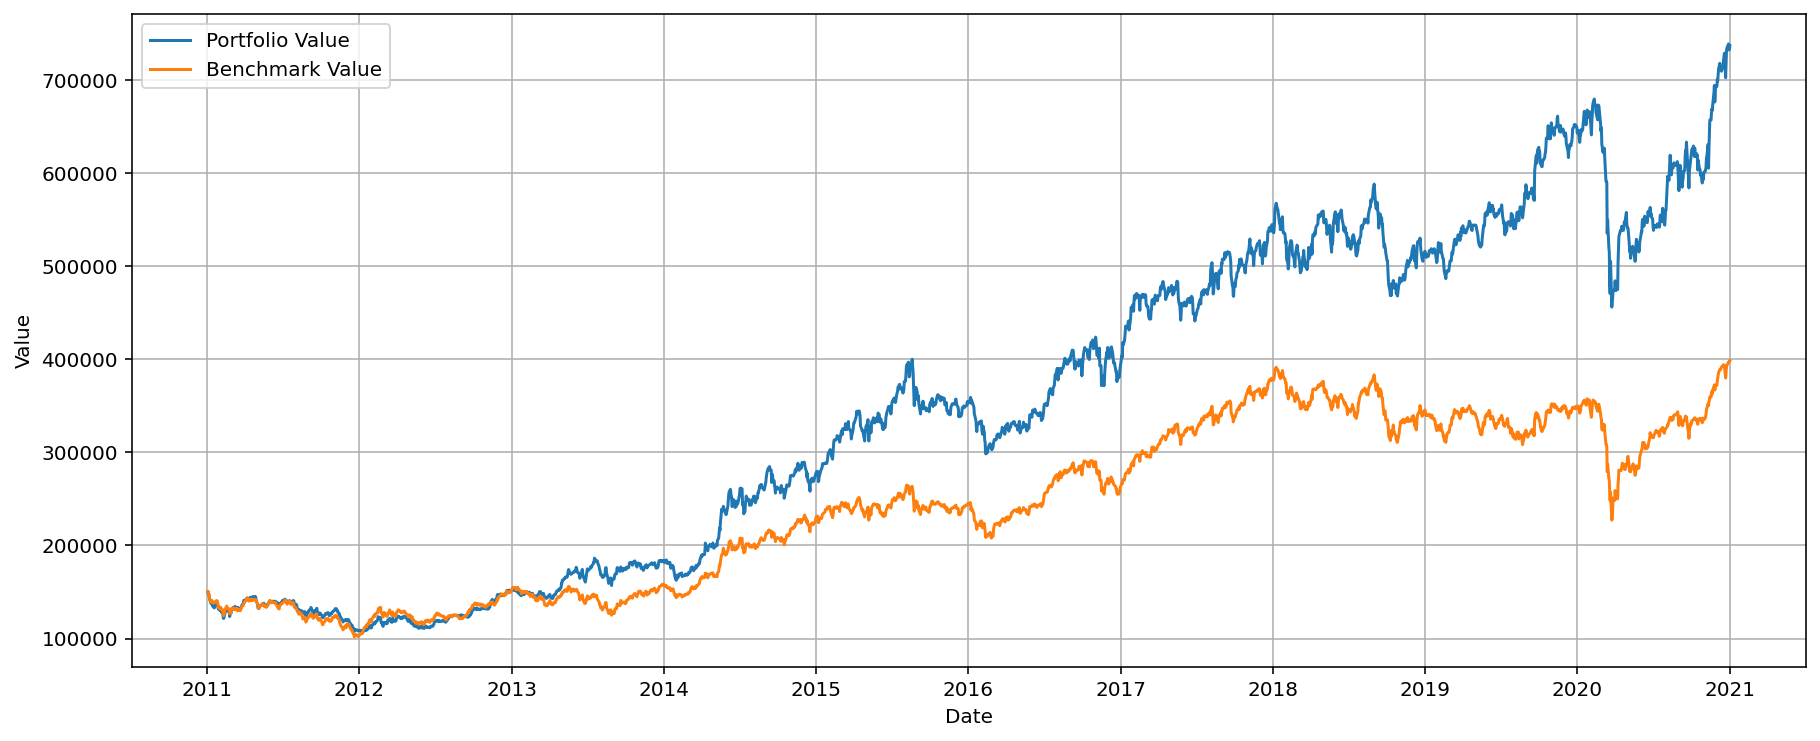

Portfolio Value: 737009.4352260001
Benchmark Value: 398648.0189338673


In [8]:
results['benchmark_returns'] = ((results.benchmark_period_return + 1) / 
                                (results.benchmark_period_return.shift(1) + 1)) - 1

results['benchmark_returns'].iloc[0] = results['benchmark_period_return'].iloc[0]

results['benchmark_value'] = np.nan

for i in range(0, len(results)):
    
    if i == 0:
        results['benchmark_value'].iloc[i] = initial_capital * (1 + results['benchmark_returns'].iloc[i])
    else:
        results['benchmark_value'].iloc[i] = results['benchmark_value'].iloc[i-1] * \
        (1 + results['benchmark_returns'].iloc[i])
        
fig = plt.figure(figsize=(15, 6))
    
plt.plot(results['portfolio_value'], label='Portfolio Value')
plt.plot(results['benchmark_value'], label='Benchmark Value')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

print('Portfolio Value:', results['portfolio_value'][-1])
print('Benchmark Value:', results['benchmark_value'][-1])

Start date,2011-01-03
End date,2020-12-31
Total months,119
,Backtest
Annual return,17.3%
Cumulative returns,391.3%
Annual volatility,20.7%
Sharpe ratio,0.87
Calmar ratio,0.53
Stability,0.93
Max drawdown,-32.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.89,2020-02-10,2020-03-23,2020-11-23,206
1,28.16,2011-01-03,2011-12-20,2012-12-20,514
2,25.41,2015-08-19,2016-02-12,2016-08-19,263
3,20.44,2018-08-31,2018-10-26,2019-09-20,276
4,15.77,2013-07-18,2013-08-28,2014-03-31,183


Stress Events,mean,min,max
US downgrade/European Debt Crisis,-0.19%,-2.28%,2.59%
Fukushima,0.41%,-1.36%,2.63%
EZB IR Event,0.30%,-0.82%,1.33%
Apr14,0.22%,-1.96%,4.09%
Oct14,0.24%,-3.76%,2.42%
Fall2015,-0.39%,-9.73%,3.48%
Recovery,0.01%,-4.03%,4.82%
New Normal,0.09%,-9.75%,7.39%


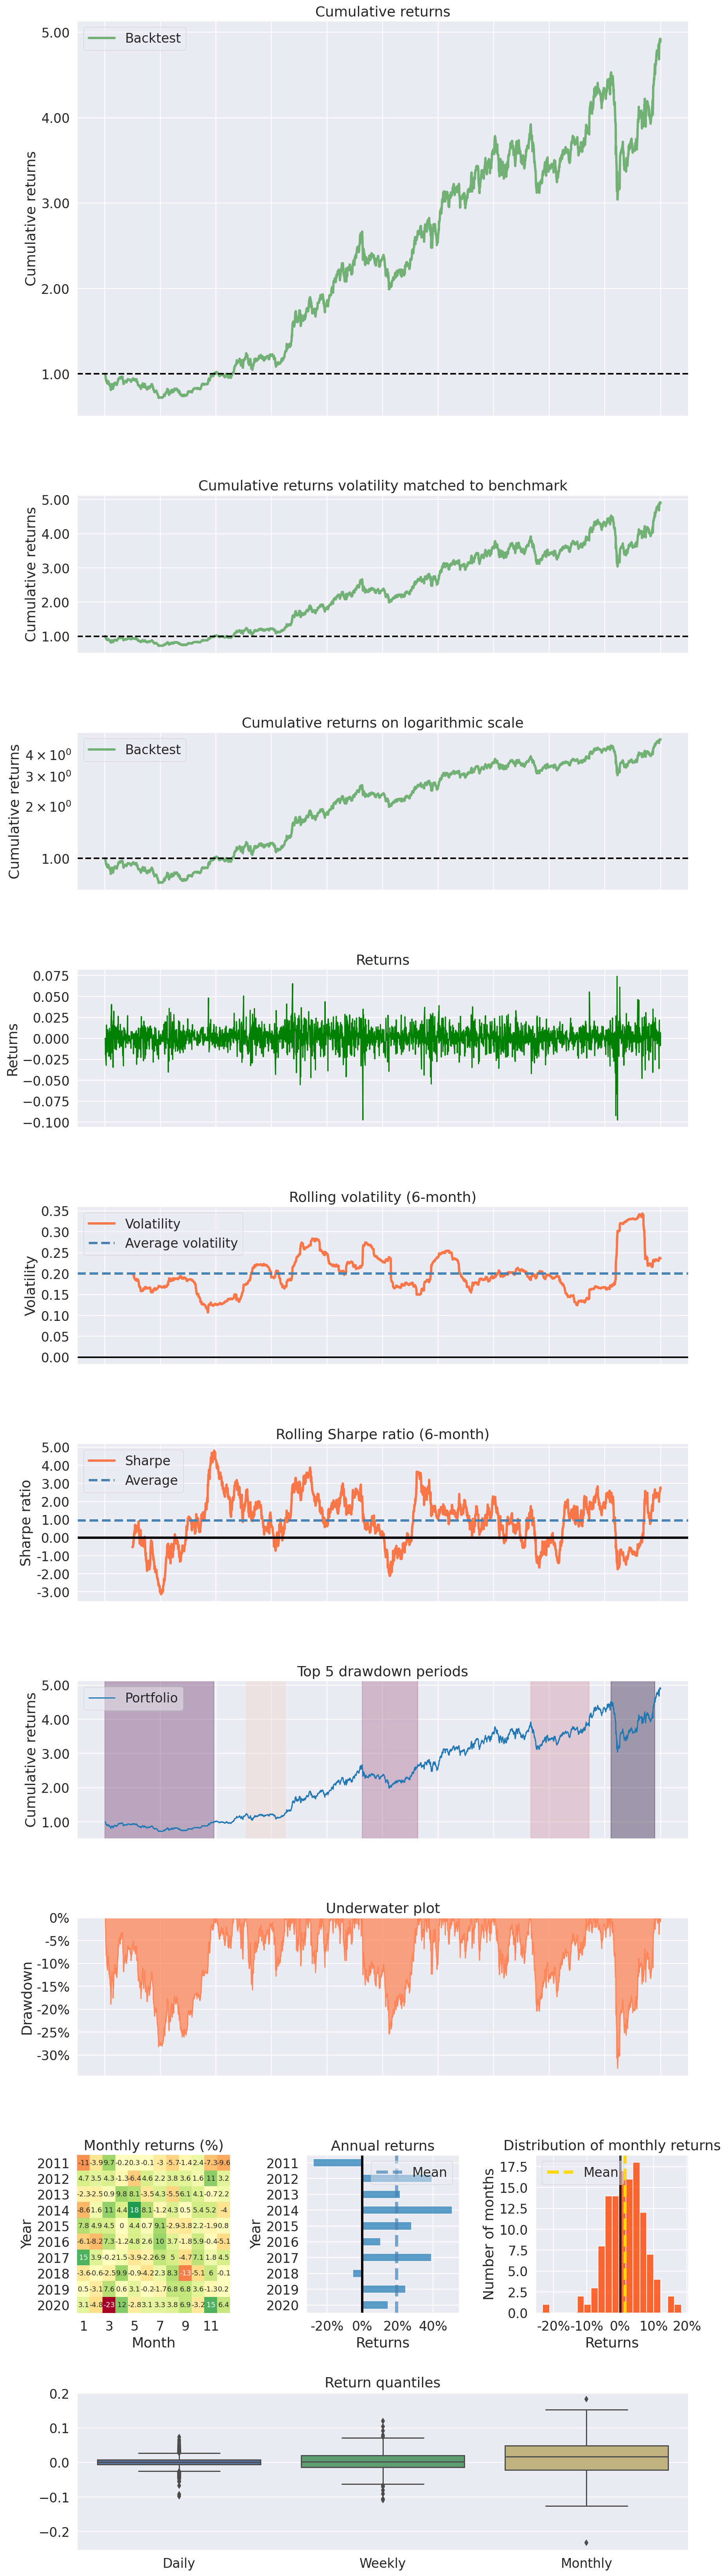

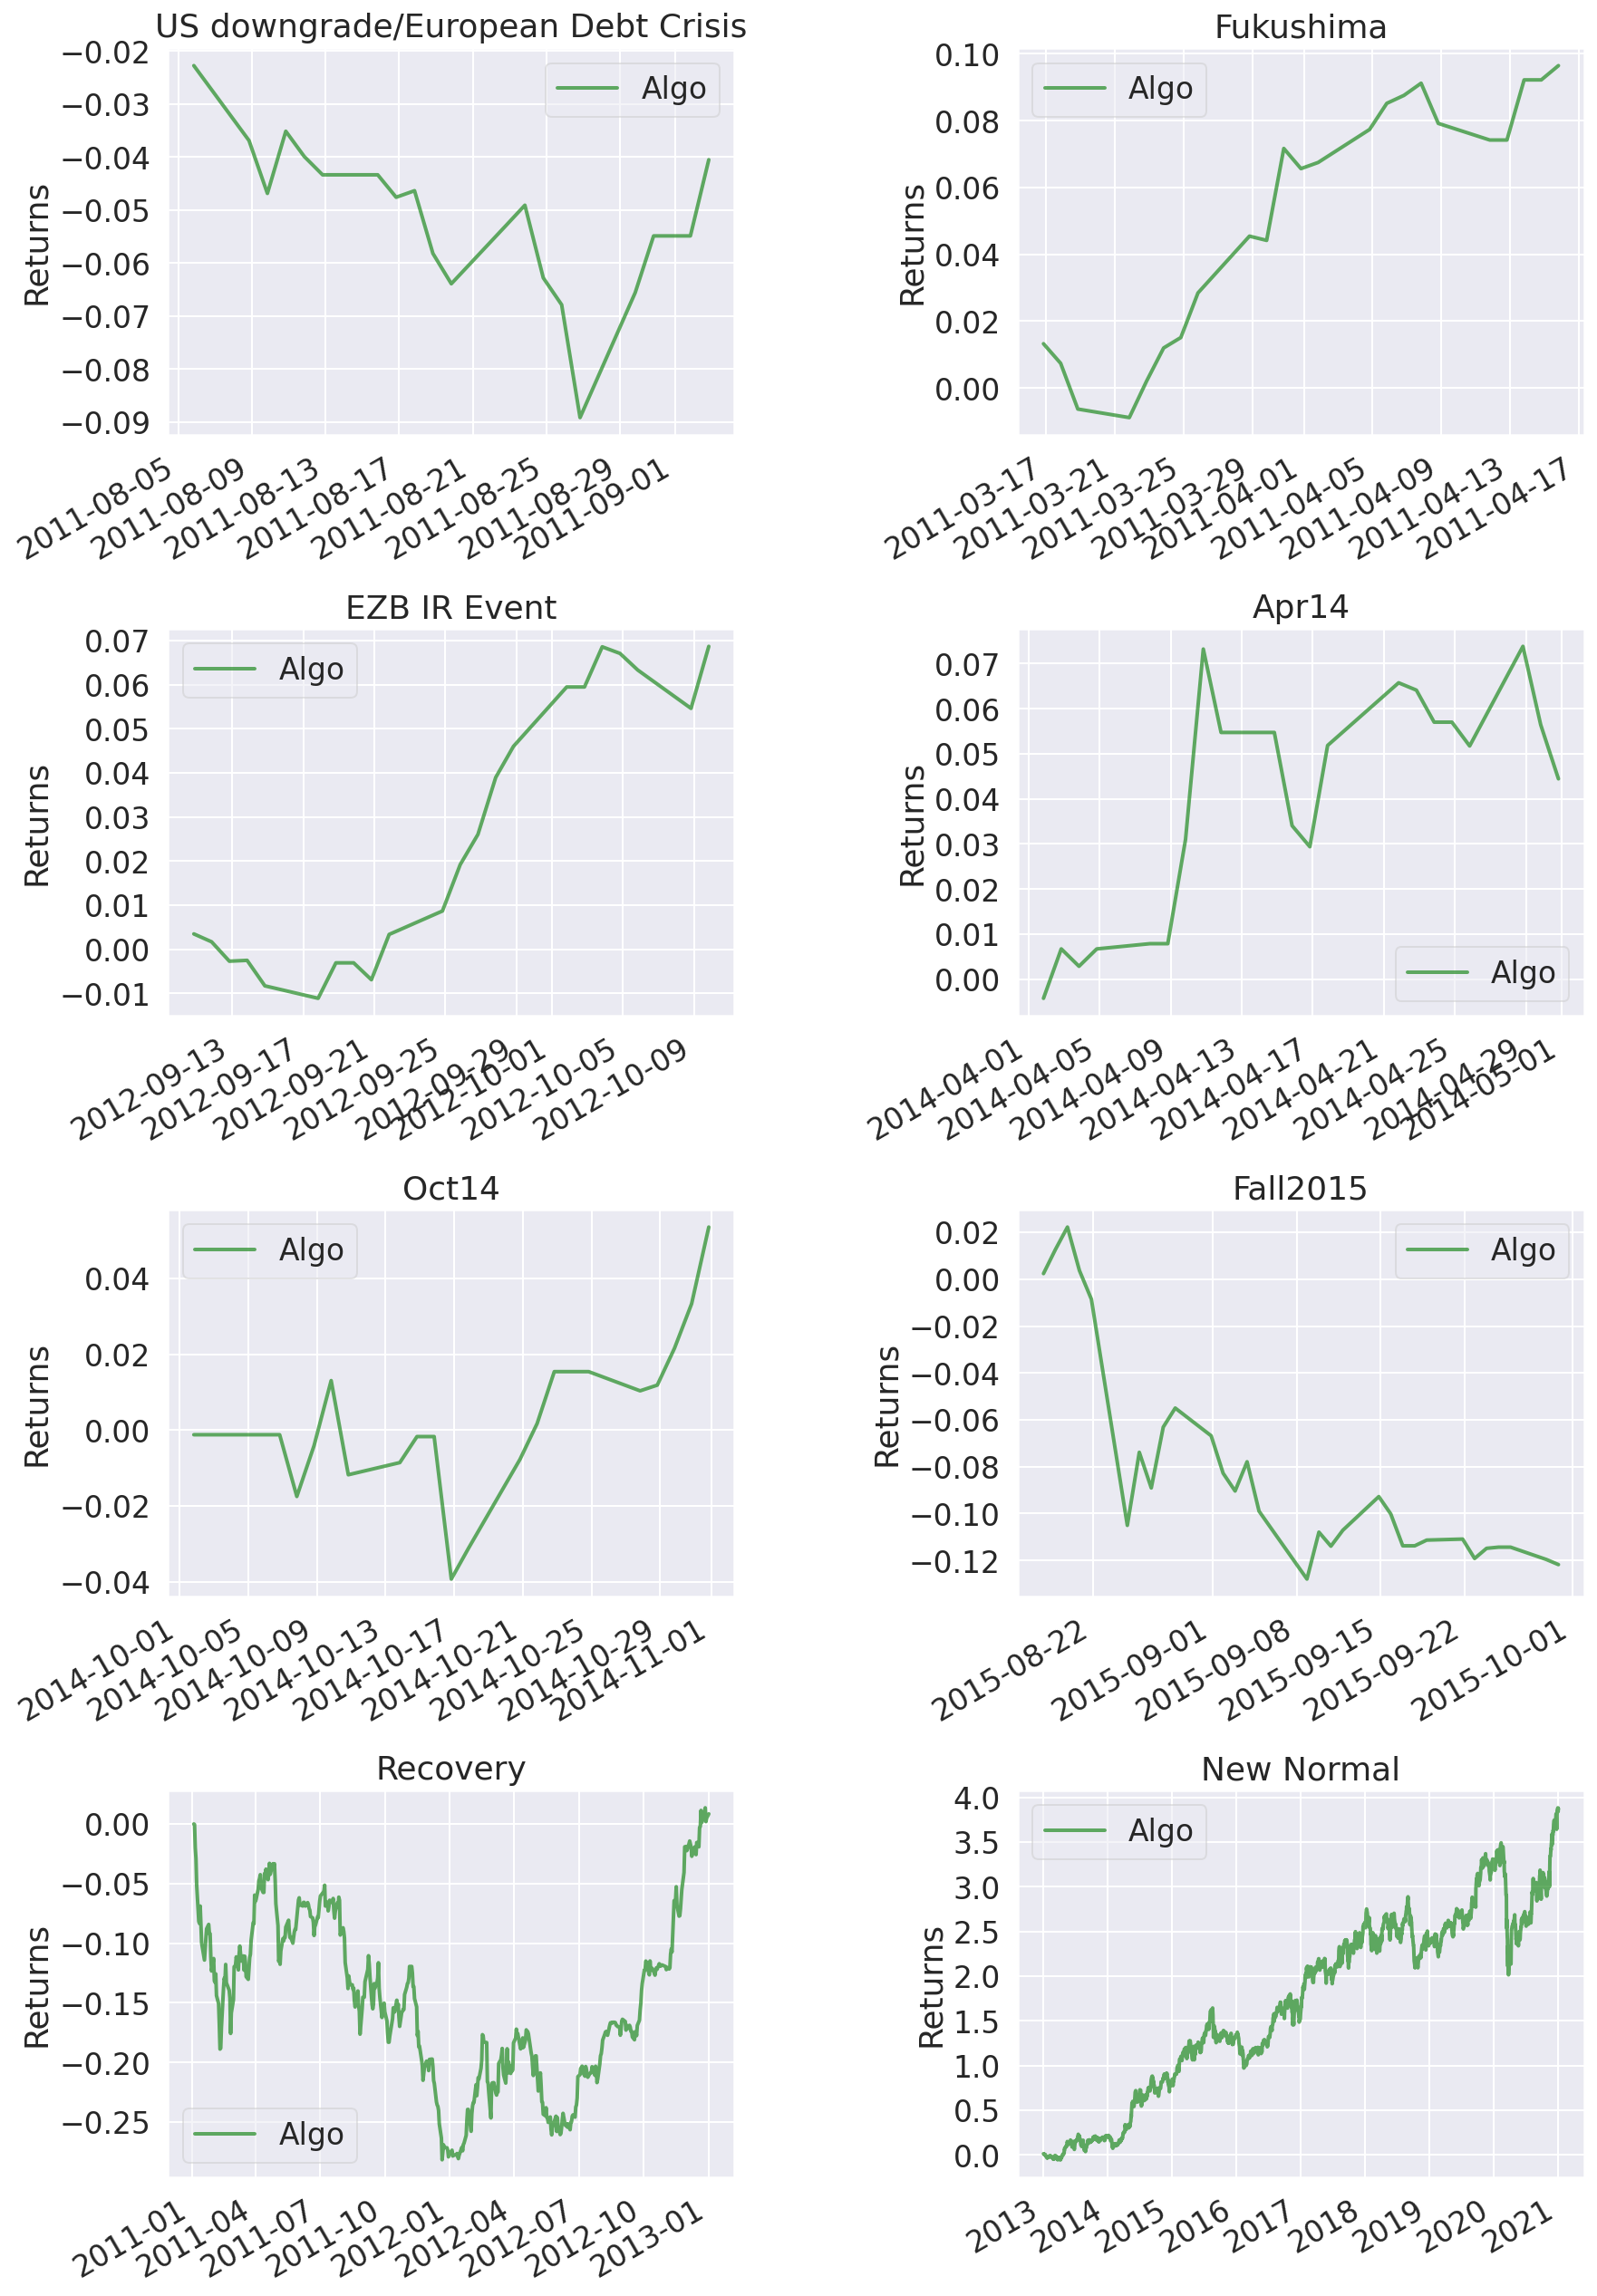

In [9]:
# returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

# pf.create_full_tear_sheet(returns, benchmark_rets=results['benchmark_returns'], 
#                           positions=positions, transactions=transactions)

pf.create_full_tear_sheet(results.returns)